In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%config InlineBackend.figure_format = 'retina'
import re
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [30]:
df = pd.read_csv('plink.genome', delim_whitespace=True)
df_callrate = pd.read_csv('callrate_real.csv')
df = df.sort_values(by='PI_HAT', ascending=False)
df.drop(['FID1','FID2'],axis = 1,inplace=True)
df[['IID1','IID2']] = df[['IID1','IID2']].astype('str')
#df['IID1'] = df['IID1'].apply(lambda x: re.sub('[^0-9]+', '', x))  # Remove non-numeric characters from the IID1 column
#df['IID2'] = df['IID2'].apply(lambda x: re.sub('[^0-9]+', '', x))
#df['IID1'] = df['IID1'].astype(int)
#df['IID2'] = df['IID2'].astype(int)
#df = df[df['PI_HAT'] > 0.001]

#filter callrate
df_callrate97 = pd.DataFrame(df_callrate[df_callrate['callrate'] > 0.97]['uid'])
df = df.merge(df_callrate97, left_on='IID1', right_on='uid', how='inner')
df = df.merge(df_callrate97, left_on='IID2', right_on='uid', how='inner')
df.drop(['uid_x','uid_y'],axis=1,inplace=True)

print(df.shape)
df.head(2)

/var/folders/gj/rlrdrwr170j78fyszkrtpknr0000gn/T/ipykernel_14568/3923385522.py:1: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('plink.genome', delim_whitespace=True)


(41356079, 12)


,IID1,IID2,RT,EZ,Z0,Z1,Z2,PI_HAT,PHE,DST,PPC,RATIO
0,41220111713475,41220111710446,UN,NaN,0.0000,0.0000,1.0,1.0000,-1,0.999993,1.0000,NaN
1,41220840117243,41220111710446,UN,NaN,0.9646,0.0354,0.0,0.0177,-1,0.747447,0.6625,2.028


In [31]:
#create outlier kit
df_mean = df['IID1'].value_counts().median()
df_std = df['IID1'].value_counts().std()
threshold_1 = df_mean + 5*(df_std)

df_mean = df['IID2'].value_counts().median()
df_std = df['IID2'].value_counts().std()
threshold_2 = df_mean + 5*(df_std)

j = pd.DataFrame(df['IID1'].value_counts())
df_outlier_1 = j[j['IID1'] > threshold_1]
df_outlier_1 = df_outlier_1.reset_index().rename(columns={'index':'uid'})
df_outlier_1 = df_outlier_1.drop('IID1',axis=1)

j = pd.DataFrame(df['IID2'].value_counts())
df_outlier_2 = j[j['IID2'] > threshold_2]
df_outlier_2 = df_outlier_2.reset_index().rename(columns={'index':'uid'})
df_outlier_2 = df_outlier_2.drop('IID2',axis=1)

df_out = pd.concat([df_outlier_1,df_outlier_2])
df_out.drop_duplicates(subset='uid', inplace=True)

#filter out outlier kit from df
df = df[~df['IID1'].isin(df_out['uid'])]
df = df[~df['IID2'].isin(df_out['uid'])]

del df_outlier_1, df_outlier_2, df_out, j

In [32]:
##################### load segment file #######################

# Define the column names
column_names = ['IID1', 'ibd1', 'IID2', 'ibd2', 'chr', 'start', 'end', 'LOD', 'cM']

# Read the file
df_seg = pd.read_csv('merged_ibd_segments.ibd', sep='\t', names=column_names)

# convert ID to chr
df_seg[['IID1','IID2']] = df_seg[['IID1','IID2']].astype('str')

###############################################################

######### merge % share and segment share #####################
# Sort IID1 and IID2 in df
df[['IID1', 'IID2']] = np.sort(df[['IID1', 'IID2']], axis=1)

# Sort IID1 and IID2 in df_seg
df_seg[['IID1', 'IID2']] = np.sort(df_seg[['IID1', 'IID2']], axis=1)

# Now merge and select columns as before
df_merged = pd.merge(df, df_seg, how='inner', on=['IID1', 'IID2'])
output_columns = ['IID1', 'IID2', 'chr', 'start', 'end', 'LOD', 'DST', 'cM', 'Z0', 'Z1', 'Z2', 'PI_HAT']
df_output = df_merged[output_columns]

# Now the find_relatives function will work with flipped IDs
def find_relatives(sample_id):
    relatives = df_output[(df_output['IID1'] == sample_id) | (df_output['IID2'] == sample_id)]
    return relatives
################################################################

del df_merged, df_seg

/var/folders/gj/rlrdrwr170j78fyszkrtpknr0000gn/T/ipykernel_14568/2922520125.py:7: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_seg = pd.read_csv('merged_ibd_segments.ibd', sep='\t', names=column_names)


In [33]:
# create full dataframe for analysis relativeness
df_com = df_output[['IID1', 'IID2', 'Z0', 'Z1', 'Z2', 'cM', 'PI_HAT']].copy()

df_com.loc[:, 'pair'] = df_com.apply(lambda row: tuple(sorted([row['IID1'], row['IID2']])), axis=1)

# Calculate the average 'cM' for each pair
df_com.loc[:, 'avg_cM'] = df_com.groupby('pair')['cM'].transform('mean')

# Count the number of occurrences of each pair and create a new column 'shared_segment'
df_com.loc[:, 'shared_segment'] = df_com.groupby('pair')['pair'].transform('count')

df_com = df_com.drop_duplicates()

df_com


,IID1,IID2,Z0,Z1,Z2,cM,PI_HAT,pair,avg_cM,shared_segment
0,41220111710446,41220111713475,0.0000,0.0,1.0000,284.219,1.0000,"(41220111710446, 41220111713475)",160.306227,22
1,41220111710446,41220111713475,0.0000,0.0,1.0000,180.909,1.0000,"(41220111710446, 41220111713475)",160.306227,22
2,41220111710446,41220111713475,0.0000,0.0,1.0000,158.200,1.0000,"(41220111710446, 41220111713475)",160.306227,22
3,41220111710446,41220111713475,0.0000,0.0,1.0000,174.558,1.0000,"(41220111710446, 41220111713475)",160.306227,22
4,41220111710446,41220111713475,0.0000,0.0,1.0000,125.705,1.0000,"(41220111710446, 41220111713475)",160.306227,22
...,...,...,...,...,...,...,...,...,...,...
1543030,41210852106303,41220840116141,0.9789,0.0,0.0211,19.009,0.0211,"(41210852106303, 41220840116141)",16.648154,13
1543031,41210852106303,41220840116141,0.9789,0.0,0.0211,14.469,0.0211,"(41210852106303, 41220840116141)",16.648154,13
1543032,41210852106303,41220840116141,0.9789,0.0,0.0211,7.149,0.0211,"(41210852106303, 41220840116141)",16.648154,13
1543033,41210852106303,41220840116141,0.9789,0.0,0.0211,7.540,0.0211,"(41210852106303, 41220840116141)",16.648154,13


In [34]:
# Relationship dictionary
relationships = {
    'Identical Twin': (0.8, 1.0),
    '1Degree(Parent/Child/FullSibling)': (0.34001, 0.7999),
    '2Degree(Grandparent/Grandchild,Aunt/Uncle,Niece/Nephew,HalfSibling)': (0.1854, 0.34),
    '3Degree': (0.0695, 0.1853),
    '4Degree': (0.01, 0.0694)
}

# Function to find the relationship given PI_HAT value
def get_relationship(pi_hat):
    for relationship, (low, high) in relationships.items():
        if low <= pi_hat <= high:
            return relationship
    return 'Unknown'

# Add the relationship column
df_com['relationship'] = df_com['PI_HAT'].apply(get_relationship)

# Add parent vs sibling
df_com.loc[(df_com['Z1'] >= 0.8) & (df_com['PI_HAT'] > 0.34001) & (df_com['PI_HAT'] < 0.7999), 'relationship'] = '1Degree(Parent/Child)'
df_com.loc[(df_com['Z1'] < 0.8) & (df_com['PI_HAT'] > 0.34001) & (df_com['PI_HAT'] < 0.7999), 'relationship'] = '1Degree(FullSibling)'

# Add 1, 2, 3 degree relationship to df
df_012 = df_com.query('relationship=="Identical Twin"|relationship=="1Degree(FullSibling)"|relationship=="1Degree(Parent/Child)"|\
                      relationship=="2Degree(Grandparent/Grandchild,Aunt/Uncle,Niece/Nephew,HalfSibling)"')

df_345 = df_com.query('relationship=="3Degree"|relationship=="4Degree"')


In [35]:
df_5 = df_345[(df_345['shared_segment'] == 1) &(df_345['relationship'] == '4Degree')].copy()
df_345_2 = df_345.drop(df_5.index)
df_5.loc[:, 'relationship'] = '5Degree'


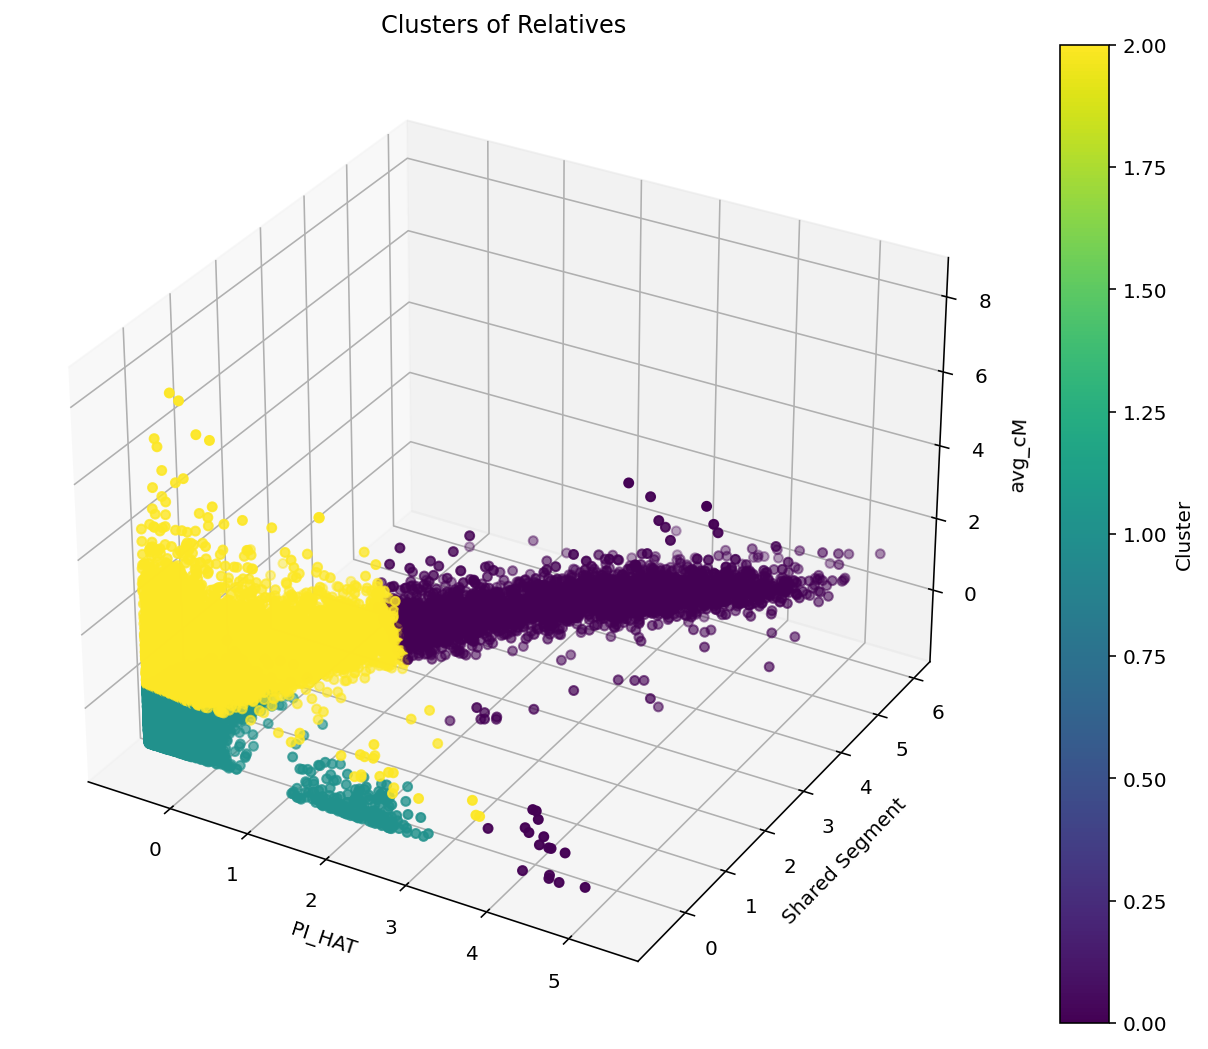

In [36]:
# Cluster the data
df_345_test = df_345_2[['IID1', 'IID2', 'PI_HAT', 'shared_segment', 'avg_cM']].drop_duplicates().copy()

# Normalize the data if necessary
scaler = StandardScaler()
df_345_test[['PI_HAT', 'shared_segment', 'avg_cM']] = scaler.fit_transform(df_345_test[['PI_HAT', 'shared_segment', 'avg_cM']])

# Determine the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_345_test[['PI_HAT', 'shared_segment', 'avg_cM']])
    wcss.append(kmeans.inertia_)

# Apply k-means
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
df_345_test['cluster'] = kmeans.fit_predict(df_345_test[['PI_HAT', 'shared_segment', 'avg_cM']])


# To visualize, since we have 3 dimensions now, we can't just use a 2D scatter plot as before. 
# We need to use a 3D plot for visualization.
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df_345_test['PI_HAT'], df_345_test['shared_segment'], df_345_test['avg_cM'], c=df_345_test['cluster'])
ax.set_title('Clusters of Relatives')
ax.set_xlabel('PI_HAT')
ax.set_ylabel('Shared Segment')
ax.set_zlabel('avg_cM')

# Add a color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')

plt.show()


In [37]:
# Define the mapping from cluster labels to relationship labels
cluster_to_relationship = {
    0: '3Degree',
    1: '5Degree',
    2: '4Degree'
}

# Apply the mapping to the 'cluster' column to create the 'relationship' column
df_345_2['relationship'] = df_345_test['cluster'].map(cluster_to_relationship)
df_345_2 = df_345_2[['IID1','IID2','PI_HAT','shared_segment','avg_cM','relationship']]

In [38]:
df_5 = df_5[['IID1','IID2','PI_HAT','shared_segment','avg_cM','relationship']]
df_012 = df_012[['IID1','IID2','PI_HAT','shared_segment','avg_cM','relationship']]

In [43]:
dfx = pd.concat([df_012, df_345_2, df_5], axis=0).reset_index(drop=True)
dfx = dfx.rename(columns={'PI_HAT':'sharing_DNA'})
dfx = dfx.drop_duplicates(subset=['IID1', 'IID2', 'sharing_DNA', 'shared_segment', 'avg_cM'])
dfx['avg_cM'] = dfx['avg_cM'].round(2)
dfx.head(2)

,IID1,IID2,sharing_DNA,shared_segment,avg_cM,relationship
0,41220111710446,41220111713475,1.0,22,160.31,Identical Twin
22,41220111710446,41220111713288,0.5,34,101.64,1Degree(Parent/Child)


In [44]:
dfx['relationship'].value_counts()

5Degree                                                                719985
4Degree                                                                 14161
1Degree(Parent/Child)                                                    7748
1Degree(FullSibling)                                                     3511
3Degree                                                                  3457
2Degree(Grandparent/Grandchild,Aunt/Uncle,Niece/Nephew,HalfSibling)      2350
Identical Twin                                                             89
Name: relationship, dtype: int64

In [45]:
dfx.sort_values('sharing_DNA',ascending=False).to_csv('dfx.csv',index=False)

In [50]:
dfx.query('IID1 == "41220110806981"| IID2 == "41220110806981"').to_csv("testdf.csv",index=False)